# $$ AI \space Democracy - A\space case\space study\space on\space corruption\space citations $$

---

<p align="justify">A corrupção é a barreira número #1 ao desenvolvimento e o motor  principal da desigualdade em Portugal. Nesse sentido, propomos o uso de ferramenteas de análise de dados e de PLN para extrair, processar e abstrair informações relevantes no âmbito da corrupção em Portugal.</p>

<p align="justify"> A ideia principal é dessenvolver ferramentas que permitam ao público geral a possibilidade de acompanhar e seguir os passos políticos dos seus representandes dentro do Parlamento, de uma forma fácil e acessível a todos através de uma interface de visualização gráfica clara dos dados. </p>

# Data

In [1]:
#@title #**Importando bibliotecas principais** {run: "auto", display-mode: "form" }

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import bokeh
import re
import time
import nltk
from IPython.core.display import display, HTML
import os
from matplotlib.colors import *
import matplotlib.image as mpimg
import matplotlib as mpl
import copy
import imageio
import math
from IPython.display import Image
import PIL

def color_text(text, color):
    colors = {
        "r" : "#F00",
        "g" : "#0F0",
        "b" : "#00F",
        "y" : "#FF0",
        "c" : "#0FF",
        "p" : "#F0F",
    }

    css_str = '<style>.Color{color:' + colors[color] +';}</style>'
    html_str = '<div class="Color"><b>' + text + '</b></div>'
    html = HTML(css_str + html_str)
    display(html)
    display(HTML(""))

time.sleep(0.3)
color_text('Concluído com sucesso!', 'g')

In [2]:
#@title #**Selecione um set de keywords:** {run: "auto", display-mode: "form" }

def get_derivatives(keywords):
    if keywords != "Corrupcao":
        color_text('Alerta: Atualmente nosso banco de palavras só conta com o tema "Corrupção"!', 'y')
    else:
        color_text('Concluído com sucesso!', 'g')
    return ['corrup']

keywords = "Corrupcao" #@param ["Corrupcao", "Meio Ambiente", "Educacao", "Saude"]

corruption_words = get_derivatives(keywords)

In [3]:
#@title #**Selecione um intervalo de datas de 2020-09-17 até 2021-02-26:** {run: "auto", display-mode: "form" }

date_start = "2020-09-17" #@param{type: "date"}
date_final = "2021-02-26"#@param{type: "date"}
    
def validate_dates(date_start, date_final):
    if date_start < "2020-09-17":
        color_text('Input de data inválido: Datas válidas começam em 2020-09-17', 'r')
        return None, None
    elif date_final > "2021-02-26":
        color_text('Input de data inválido: Datas válidas terminam em 2021-02-26', 'r')
        return None, None
    elif date_start > date_final:
        color_text('Aviso: Parece que você inverteu a ordem das datas, foi corrigido para você', 'y')
        temp = date_start
        date_start, date_final = date_final, date_start
        return date_start, date_final
    else:
        color_text('Concluído com sucesso!', 'g')
        return date_start, date_final

date_start, date_final = validate_dates(date_start, date_final)

In [4]:
#@title #**Carregando dados** {run: "auto", display-mode: "form" }

import re

projects = pd.read_csv("/content/iniciativas.csv")
projects.drop('Unnamed: 0', axis=1, inplace=True)
projects.columns = ['type', 'number', 'session', 'authorship', 'description', 'url']
projects['title'] = projects['type'] + ' ' + projects['number']
dialogs =  pd.read_csv("/content/dialog_lines_database_initiatives.csv")
#dialogs.drop(['Y_true'], axis = 1, inplace=True)
#dialogs.drop(['Y_true', 'Tokenized_Text', 'Clean_Tokens', 'Normalized_Tokens',
 #      'Vectors', 'Normalized_Tokens_String'], axis = 1, inplace=True)

#dialogs.drop('Unnamed: 0', axis=1, inplace=True)

def find_words(data_frame, fields, words):
    series = [data_frame[field] for field in fields]
    positions = pd.DataFrame()
    for serie in series:
        for word in words:
            positions[serie.name+'_'+word+"_pos"] = serie.str.lower().str.find(word)
    return positions

def get_citations(data_frame, fields, words):
    positions = find_words(data_frame, fields, words)
    out_list = [] # pd.DataFrame(columns = data_frame.columns)
    i = 0
    for ind in positions.index:
        has_found = False
        for field_word in positions:
            if (positions[field_word][ind] != -1):
                has_found = True
                break
        if(has_found):
            #print(data_frame.iloc[ind].values)
            out_list.append(data_frame.iloc[ind].values)
            i = i + 1
    return pd.DataFrame(out_list, columns = data_frame.columns)

def get_related(full_dataframe, citation_dataframe, key_fields):
    citation_dataframe['key'] = citation_dataframe[key_fields[0]]
    full_dataframe['key'] = full_dataframe[key_fields[0]]
    for i in range(1, len(key_fields)):
        citation_dataframe['key'] = citation_dataframe['key'] + citation_dataframe[key_fields[i]]
        full_dataframe['key'] = full_dataframe['key'] + full_dataframe[key_fields[i]]
    topics = citation_dataframe['key'].unique()
    #print(topics)
    to_out = pd.DataFrame(columns = full_dataframe.columns)
    for topic in topics:
        to_out = to_out.append(full_dataframe.loc[full_dataframe['key'] == topic])
    return to_out

def get_related_projects(citations_df, projects_df):
    #print(citations_df['Subject'].unique())
    to_out = pd.DataFrame(columns = projects_df.columns)
    for subject in [str(sub) for sub in citations_df['Initiatives'].unique()]:
        #print('subject', subject)
        titles = subject.split(', ')
        for title in titles:
            to_out = to_out.append(projects_df.loc[projects_df['title'] == title])
    return to_out

def clean(citations):
    citations.dropna(axis=0, inplace=True)

    not_politicians = ['Presidente', 'Secretária', 'Secretário', 'Ministra', 'Ministro']
    for not_politician in not_politicians:
        citations.loc[citations['Person'].str.contains(not_politician), 'Party'] = np.nan
    citations.dropna(axis=0, inplace=True)

    citations.replace(to_replace='Partido Socialista', value='PS', inplace=True)
    citations.replace(to_replace='SD', value=np.nan, inplace=True)
    citations.replace(to_replace='N insc.', value=np.nan, inplace=True)

    #Arrumando nomes que não tinham o devido espaçamento
    regex = re.compile("[a-zá-ú][A-Z]")
    for i in range(3):
        for person in citations['Person']:
            person = str(person)
            match = re.search(regex, person)
            if match:
                citations['Person'].replace(to_replace=person,
                                            value=person[:match.start()+1] + " " + person[match.end()-1:],
                                            inplace=True)
    for col in ['Person', 'Text']:
        citations[col].replace(to_replace='Rosário Gamboa', value='Rosário Gambôa', inplace=True)
        citations[col].replace(to_replace='António Malo de Abreu', value='António Maló de Abreu', inplace=True)
        citations[col].replace(to_replace='Inês de Sousa Leal', value='Inês de Sousa Real', inplace=True)
        citations[col].replace(to_replace='Vera Brás', value='Vera Braz', inplace=True)
        citations[col].replace(to_replace='Nélson Basílio Silva', value='Nelson Basílio Silva', inplace=True)
        citations[col].replace(to_replace='André Pinotes Baptista', value='André Pinotes Batista', inplace=True)
        citations[col].replace(to_replace='Claúdia Santos', value='Cláudia Santos', inplace=True)
        citations[col].replace(to_replace='Secretáriode Estado do Comércio, Serviços e Defesa do Consumidor',
                               value='Secretário de Estado do Comércio, Serviços e Defesa do Consumidor', inplace=True)
        citations[col].replace(to_replace='Secretáriade Estado da Habitação',
                               value='Secretária de Estado da Habitação', inplace=True)
        citations[col].replace(to_replace='Maria Antónia Almeida Santos',
                               value='Maria Antónia de Almeida Santos', inplace=True)

    citations.replace(to_replace='Partido Socialista', value='PS', inplace=True)
    citations.replace(to_replace='SD', value=np.nan, inplace=True)
    citations.replace(to_replace='N insc.', value=np.nan, inplace=True)
    citations['Person'].replace(to_replace='António Malo de Abreu', value='António Maló de Abreu', inplace=True)
    citations['Person'].replace(to_replace='AndréSilva', value='André Silva', inplace=True)
    citations['Person'].replace(to_replace='Inês de Sousa Leal', value='Inês de Sousa Real', inplace=True)
    citations['Person'].replace(to_replace='AntónioFilipe', value='António Filipe', inplace=True)
    citations['Person'].replace(to_replace='PedroDelgadoAlves', value='Pedro Delgado Alves', inplace=True)
    citations['Person'].replace(to_replace='PedroFilipeSoares', value='Pedro Filipe Soares', inplace=True)
    citations['Person'].replace(to_replace='Ana Catarina MendonçaMendes', value='Ana Catarina Mendonça Mendes', inplace=True)
    return citations

direct_citations = clean(get_citations(dialogs, ['Text'], corruption_words))
direct_projects = get_citations(projects, ['description'], corruption_words)
indirect_citations = clean(get_related(dialogs, direct_citations, ['Date', 'Initiatives']))
indirect_projects = get_related_projects(direct_citations, projects)

def load_infos(custom_info_dict=None):
    if custom_info_dict == None:
            infos = {
                'PS'     : {
                    'color' : '#FF66FF',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido4_0.gif',
                    'coordinates' : (-2.5, 3.1),
                },
                'PSD'    : {
                    'color' : '#F68A21',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido3_1.gif',
                    'coordinates' : (1.6, -1),
                },
                'BE'     : {
                    'color' : '#D21F1B',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido14_0.gif',
                    'coordinates' : (-3.5, 0.5),
                },
                'PCP'    : {
                    'color' : '#FF0000',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido1_0.gif',
                    'coordinates' : (-3.5, -4.7),
                },
                'CDS-PP' : {
                    'color' : '#0091DC',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido2_0.gif',
                    'coordinates' : (2.5, -2.1),
                },
                'PAN'    : {
                    'color' : '#036A84',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/pan_2014.jpg',
                    'coordinates' : (-3.4, 3.2),
                },
                'PEV'    : {
                    'color' : '#73BE43',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido10_0.gif',
                    'coordinates' : (-2.1, -2.5),
                },
                'CH'     : {
                    'color' : '#333399',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_chega.png',
                    'coordinates' : (5, -3.6),
                },
                'IL'     : {
                    'color' : '#00AEEE',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_liberal.png',
                    'coordinates' : (1, 0.5) #???,
                },
                'JPP'    : {
                    'color' : '#0E766D',
                    'orientation' : 'Centro',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_jpp.jpg',
                    'coordinates' : (0, 0) #???,
                },
                'PPM'    : {
                    'color' : '#014A94',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido5_0.gif',
                    'coordinates' : (1.25, -2.1) #???,
                },
                'NC'     : {
                    'color' : '#FEAB19',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_nos_cidadaos.jpg',
                    'coordinates' : (0, 0.9) #???,
                },
                'L'      : {
                    'color' : '#98C75A',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/livre.png',
                    'coordinates' : (-4.6, 2.7),
                },
            }
            return infos
    else:
        return custom_info_dict

'''
def carregamento():
    bar = "|" + "-"*32 + "|"
    wait = list(np.random.rand(10))

    print("Collecting Databases from the origin", '\n')

    for i in range(10):
        bar = bar.replace('-', '█', 3)
        print('\t', bar + str(i*10) + "%")
        time.sleep(wait[i])
    print('\t', "|████████████████████████████████|100%", '\n')
    color_text('Successfully load Minutes_Database.csv and Initiatives.csv', 'g')
carregamento()
'''

'\ndef carregamento():\n    bar = "|" + "-"*32 + "|"\n    wait = list(np.random.rand(10))\n\n    print("Collecting Databases from the origin", \'\n\')\n\n    for i in range(10):\n        bar = bar.replace(\'-\', \'█\', 3)\n        print(\'\t\', bar + str(i*10) + "%")\n        time.sleep(wait[i])\n    print(\'\t\', "|████████████████████████████████|100%", \'\n\')\n    color_text(\'Successfully load Minutes_Database.csv and Initiatives.csv\', \'g\')\ncarregamento()\n'

# Other Graphs

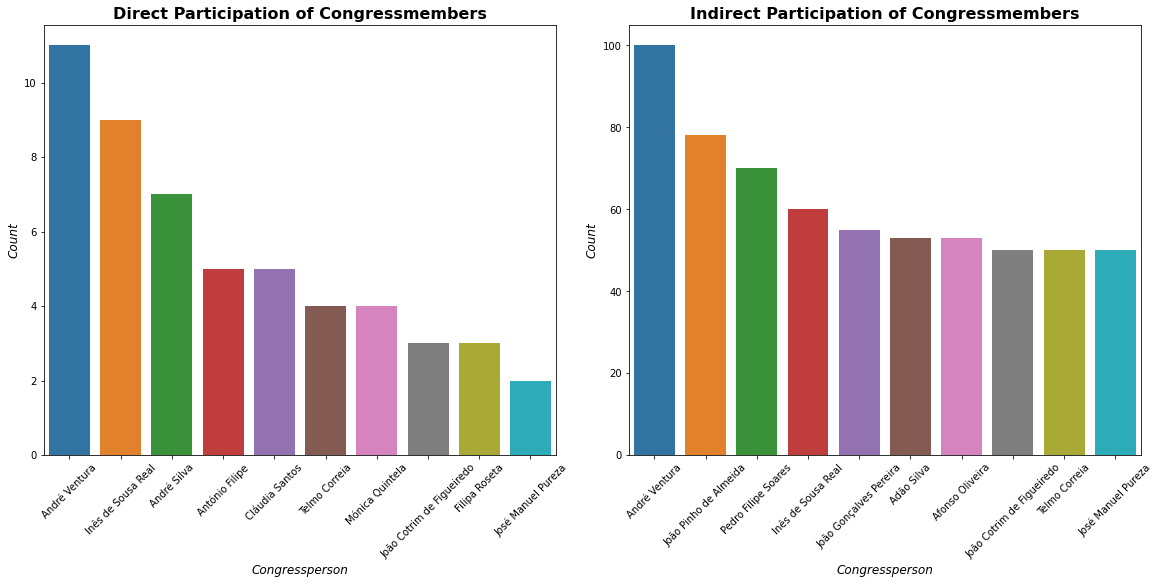

In [5]:
#@title #**Estatísticas gerais das pessoas** { display-mode: "form" }

def people_statistics(direct_citations, indirect_citations, number=25):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16,8))
    #fig.suptitle('Gráficos de Estatísticas básicas de Pessoas')
    axs[0].set_title('Direct Participation of Congressmembers', fontweight='bold', fontsize=16)
    axs[1].set_title('Indirect Participation of Congressmembers', fontweight='bold', fontsize=16)

    sns.countplot(ax=axs[0], x='Person', data= direct_citations,
                  order=direct_citations['Person'].value_counts().iloc[:number].index)
    sns.countplot(ax=axs[1], x='Person', data= indirect_citations[-(indirect_citations['Person'] == 'Presidente')],
                  order=indirect_citations['Person'].value_counts().iloc[:number].index)
    
    axs[0].set_xlabel('Congressperson', fontstyle='italic', fontsize=12)
    axs[1].set_xlabel('Congressperson', fontstyle='italic', fontsize=12)
    axs[0].set_ylabel('Count', fontstyle='italic', fontsize=12)
    axs[1].set_ylabel('Count', fontstyle='italic', fontsize=12)

    axs[0].tick_params(axis='x', rotation=45)
    axs[1].tick_params(axis='x', rotation=45)

    plt.savefig("my_plot.pdf", format='pdf', dpi=500)
    plt.show()

    plt.show()

people_statistics(direct_citations, indirect_citations, 10)

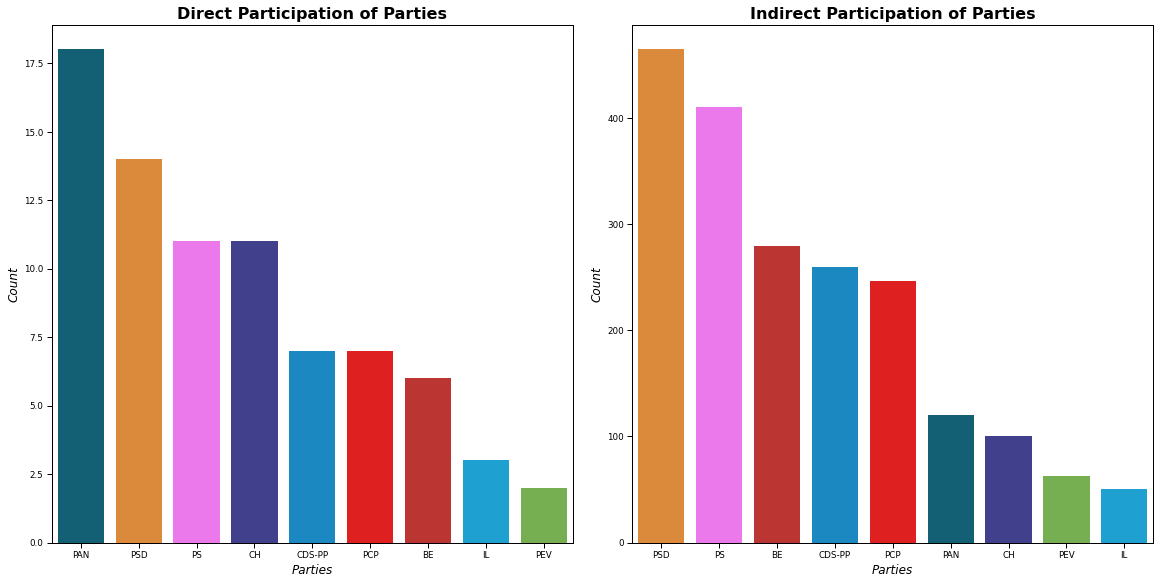

In [6]:
#@title #**Estatísticas gerais dos partidos** { display-mode: "form" }

sns.set_context("paper")
#plt.figsize = (8, 6)

def parties_statistics(direct_citations, indirect_citations, infos=load_infos()):
    
    party_colors = {}
    for party in infos:
        party_colors[party] = infos[party]['color']
    
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16,8))
    #fig.suptitle('Party Participation Statistics Graph', fontsize='large', fontweight='bold')
    axs[0].set_title('Direct Participation of Parties', fontweight='bold', fontsize=16)
    axs[1].set_title('Indirect Participation of Parties', fontweight='bold', fontsize=16)

    sns.countplot(ax=axs[0], x='Party',
                  data= direct_citations, palette=party_colors,
                  order=direct_citations['Party'].value_counts().index)
    
    sns.countplot(ax=axs[1], x='Party', 
                  data= indirect_citations, palette=party_colors,
                  order=indirect_citations['Party'].value_counts().index)

    axs[0].set_xlabel('Parties', fontstyle='italic', fontsize=12)
    axs[1].set_xlabel('Parties', fontstyle='italic', fontsize=12)
    axs[0].set_ylabel('Count', fontstyle='italic', fontsize=12)
    axs[1].set_ylabel('Count', fontstyle='italic', fontsize=12)

    plt.savefig("my_plot.pdf", format='pdf', dpi=500)
    plt.show()

parties_statistics(direct_citations, indirect_citations)

ValueError: ignored

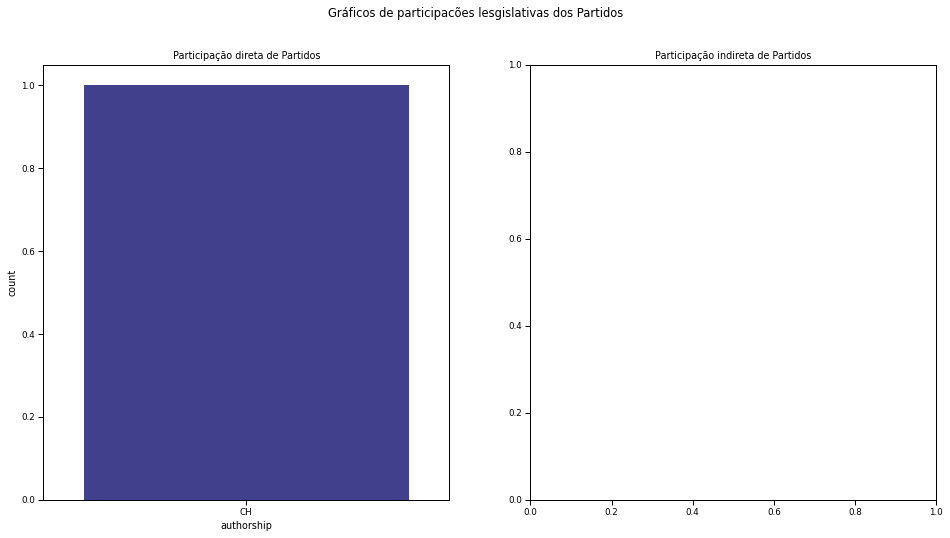

In [7]:
#@title #**Estatísticas das participações legislativas partidos** { display-mode: "form" }

def parties_projects(direct_projects, indirect_projects, infos=load_infos()):
    
    party_colors = {}
    for party in infos:
        party_colors[party] = infos[party]['color']
    party_colors['PAR'] = '#a8a232'
    party_colors['CACDLG'] = '#8332a8'


    fig, axs = plt.subplots(1, 2, constrained_layout=False, figsize=(16,8))
    fig.suptitle('Gráficos de participacões lesgislativas dos Partidos')
    axs[0].set_title('Participação direta de Partidos')
    axs[1].set_title('Participação indireta de Partidos')

    sns.countplot(ax=axs[0], x='authorship',
                  data= direct_projects, palette=party_colors,
                  order=direct_projects['authorship'].value_counts().index)
    
    sns.countplot(ax=axs[1], x='authorship', 
                  data= indirect_projects, palette=party_colors,
                  order=indirect_projects['authorship'].value_counts().index)

    axs[0].tick_params(axis='x', rotation=90)
    axs[1].tick_params(axis='x', rotation=90)
    
    plt.show()

indirect_projects['authorship'].loc[indirect_projects['authorship'] == 'Comissão de Assuntos Constitucionais, Direitos, Liberdades e Garantias'] = 'CACDLG'

parties_projects(direct_projects, indirect_projects)

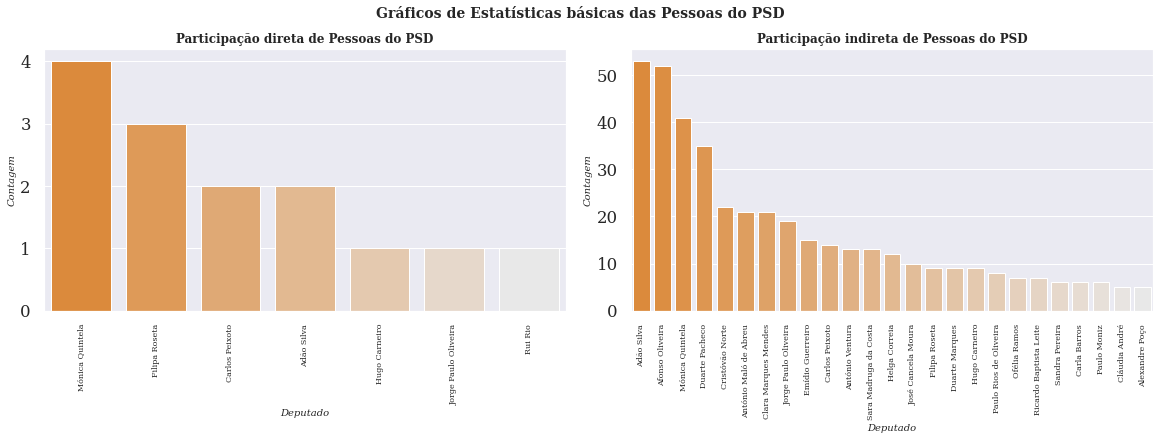

'\nimport matplotlib.pyplot as plt\nsns.set_context("paper")\nplt.style.available\nplt.style.use(\'seaborn\')\n\nsns.set_palette(sns.color_palette("tab10"))\n\nplt.rc(\'font\', family=\'serif\')\n\nsns.set(font_scale=1.5, rc={\'text.usetex\' : False})\nplt.rc(\'font\', family=\'serif\')\n#plt.style.use(\'tex\')\n\nfig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(1, 8))\n\nnumber = 10\n\ninfos=load_infos()\n\nparty_colors = {}\nfor party in infos:\n    party_colors[party] = infos[party][\'color\']\n\n\nsns.countplot(ax=axs[0, 0], x=\'Person\', data=direct_citations,\n              order=direct_citations[\'Person\'].value_counts().iloc[:number].index,\n              palette=sns.color_palette("tab10"))\nsns.countplot(ax=axs[0, 1], x=\'Person\', data= indirect_citations[-(indirect_citations[\'Person\'] == \'Presidente\')],\n              order=indirect_citations[\'Person\'].value_counts().iloc[:number].index,\n              palette=sns.color_palette("tab10"))\n\nsns.countplo

In [16]:
#@title #**Estatísticas das pessoas dos partidos** {run: "auto", display-mode: "form" }

def persons_byparty_statistics(direct_citations, indirect_citations, party, number=25, infos=load_infos()):
    direct_party = direct_citations.loc[direct_citations['Party'] == party]
    indirect_party = indirect_citations.loc[indirect_citations['Party'] == party]

    sns.set_context("paper")
    plt.style.available
    plt.style.use('seaborn')
    plt.rc('font', family='serif')

    sns.set(font_scale=1.5, rc={'text.usetex' : False})
    plt.rc('font', family='serif')

    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16,6))
    fig.suptitle('Gráficos de Estatísticas básicas das Pessoas do {}'.format(party), fontweight='bold', fontsize=14)
    axs[0].set_title('Participação direta de Pessoas do {}'.format(party), fontweight='bold', fontsize=12)
    axs[1].set_title('Participação indireta de Pessoas do {}'.format(party), fontweight='bold', fontsize=12)

    party_color = infos[party]['color']
    
    if len(direct_party) >= number:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=number)
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[0], x='Person',
                data= direct_party,
                palette=cmap,
                order=direct_party['Person'].value_counts().iloc[:number].index)
    elif len(direct_party) > 0:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=len(direct_party['Person'].unique()))
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[0], x='Person',
                data= direct_party,
                palette=cmap,
                order=direct_party['Person'].value_counts().iloc[:number].index)
    else:
        axs[0].text(
            x=1.75/15.5,
            y=0.5,
            s='Dados insuficientes para geração do gráfico',
            fontdict = dict(size=16, color='black', fontweight='bold')
        )
        
    if len(indirect_party) >= number:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=number)
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[1], x='Person',
                data= indirect_party,
                palette=cmap,
                order=indirect_party['Person'].value_counts().iloc[:number].index)
    else:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=len(indirect_party['Person'].unique()))
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[1], x='Person',
                data= indirect_party,
                palette=cmap,
                order=indirect_party['Person'].value_counts().iloc[:number].index)
    
    axs[0].tick_params(axis='x', rotation=90, labelsize=8)
    axs[1].tick_params(axis='x', rotation=90, labelsize=8)

    axs[0].set_xlabel('Deputado', fontstyle='italic', fontsize=10)
    axs[1].set_xlabel('Deputado', fontstyle='italic', fontsize=10)

    axs[0].set_ylabel('Contagem', fontstyle='italic', fontsize=10)
    axs[1].set_ylabel('Contagem', fontstyle='italic', fontsize=10)


    plt.show()

#@markdown Selecione um partido
partido = 'PSD' #@param['BE', 'CDS-PP', 'CH', 'IL', 'PAN', 'PCP', 'PEV', 'PS', 'PSD']
persons_byparty_statistics(direct_citations, indirect_citations, partido)

'''
import matplotlib.pyplot as plt
sns.set_context("paper")
plt.style.available
plt.style.use('seaborn')

sns.set_palette(sns.color_palette("tab10"))

plt.rc('font', family='serif')

sns.set(font_scale=1.5, rc={'text.usetex' : False})
plt.rc('font', family='serif')
#plt.style.use('tex')

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(1, 8))

number = 10

infos=load_infos()

party_colors = {}
for party in infos:
    party_colors[party] = infos[party]['color']


sns.countplot(ax=axs[0, 0], x='Person', data=direct_citations,
              order=direct_citations['Person'].value_counts().iloc[:number].index,
              palette=sns.color_palette("tab10"))
sns.countplot(ax=axs[0, 1], x='Person', data= indirect_citations[-(indirect_citations['Person'] == 'Presidente')],
              order=indirect_citations['Person'].value_counts().iloc[:number].index,
              palette=sns.color_palette("tab10"))

sns.countplot(ax=axs[1, 0], x='Party',
            data= direct_citations, palette=party_colors,
            order=direct_citations['Party'].value_counts().index)
sns.countplot(ax=axs[1, 1], x='Party', 
            data= indirect_citations, palette=party_colors,
            order=indirect_citations['Party'].value_counts().index)

axs[0, 1].set_title('Top 10 Menções Indiretas por Parlamentar', fontweight='bold', fontsize=14)
axs[0, 0].set_title('Top 10 Menções Diretas por Parlamentar', fontweight='bold', fontsize=14)
axs[1, 0].set_title('Menções Diretas por Partido', fontweight='bold', fontsize=14)
axs[1, 1].set_title('Menções Indiretas por Partido', fontweight='bold', fontsize=14)

axs[0, 0].set_xlabel('Parlamentar', fontstyle='italic', fontsize=10)
axs[0, 1].set_xlabel('Parlamentar', fontstyle='italic', fontsize=10)
axs[1, 0].set_xlabel('Partido', fontstyle='italic', fontsize=10)
axs[1, 1].set_xlabel('Partido', fontstyle='italic', fontsize=10)
axs[0, 0].set_ylabel('Contagem', fontstyle='italic', fontsize=10)
axs[0, 1].set_ylabel('Contagem', fontstyle='italic', fontsize=10)
axs[1, 0].set_ylabel('Contagem', fontstyle='italic', fontsize=10)
axs[1, 1].set_ylabel('Contagem', fontstyle='italic', fontsize=10)

axs[0, 0].tick_params(axis='both', rotation=45, labelsize=8)
axs[0, 1].tick_params(axis='both', rotation=45, labelsize=8)
axs[1, 0].tick_params(axis='both', labelsize=8)
axs[1, 1].tick_params(axis='both', labelsize=8)

plt.savefig("paper_graphs.png", format='png', dpi=500)
plt.show()
'''

# Gif

In [ ]:
#@title #**Gráfico político-econômico animado das citações diretas** {run: "auto", display-mode: "form" }

def create_dataframes(citations, infos=load_infos()):
    df_dict = {}
    dates = citations['Date'].unique().tolist()
    grouped = citations.groupby(citations['Date'])
    
    for i in range(len(dates)):

        group = grouped.get_group(citations['Date'].unique().tolist()[i])

        df_dict[str(dates[i])] = {            
            'Party' : [],
            'Count' : [],
            'Color' : [],
            'Orientation' : [],
            'Image' : [],
            'X_coordinate' : [],
            'Y_coordinate' : [],
        }
        
        for party in infos:
            
            df_dict[str(dates[i])]['Party'].append(party)
            df_dict[str(dates[i])]['Count'].append(len(group.loc[group['Party'] == party]))
            df_dict[str(dates[i])]['Color'].append(infos[party]['color'])
            df_dict[str(dates[i])]['Orientation'].append(infos[party]['orientation'])
            df_dict[str(dates[i])]['Image'].append(infos[party]['url_image'])
            df_dict[str(dates[i])]['X_coordinate'].append(infos[party]['coordinates'][0])
            df_dict[str(dates[i])]['Y_coordinate'].append(infos[party]['coordinates'][1])

        df_dict[str(dates[i])] = pd.DataFrame(df_dict[str(dates[i])])

    dates = [str(date) for date in dates]
    dates.sort()

    return df_dict, dates

def create_graph(df, date, normalization=(0, 405)):
    colors = {}

    for i in range(len(df)):
        colors[df['Party'][i]] = df['Color'][i]

    sns.set_style('darkgrid')
    sns.set_context('paper')
    sns.set(font_scale=1.1)

    plt.figure(figsize=(14, 14))
    ax = sns.scatterplot(x='X_coordinate', y='Y_coordinate', data=df,
                         palette=colors, hue='Party', size='Count', 
                         alpha=0.5, sizes=(100, 10000),
                         size_norm=(normalization[0], normalization[1]))

    ax.set_title('Eixo político-econômico: Acumulado até ' + str(date), y=1.04, fontsize='x-large')

    ax.set(xlim=(-5.5, 5.5), ylim=(-5.5, 5.5))
    
    ax.axhline(y=0, linewidth=0.5, color='black')
    ax.axvline(x=0, linewidth=0.5, color='black')

    for i in range(len(df)):
        ax.annotate(df['Party'][i],
                    xy=(df['X_coordinate'][i], df['Y_coordinate'][i]),
                    xycoords='data',
                    xytext=(df['X_coordinate'][i]-0.15, df['Y_coordinate'][i]+0.15),
                    )
        ax.annotate(df['Count'][i],
            xy=(df['X_coordinate'][i], df['Y_coordinate'][i]),
            xycoords='data',
            xytext=(df['X_coordinate'][i]+0.1, df['Y_coordinate'][i]-0.1),
            )
    
    ax.legend(fancybox=True, shadow=True)

    plt.xticks(np.arange(-5, 6, 1), 5*['']+['Conservador']+5*[''], fontsize='large')
    plt.yticks(np.arange(-5, 6, 1), 5*['']+['Esquerda']+5*[''], fontsize='large')

    labelx = ax.set_xlabel('Liberal', fontsize='large')
    ax.xaxis.set_label_coords(0.5, 1.03)

    labely = ax.set_ylabel('Direita', fontsize='large', rotation='horizontal')
    ax.yaxis.set_label_coords(1.04, 0.489)
    
    ax.get_legend().remove()
    
    plt.close()

    return ax.get_figure()

def acumulative(citations_dict, citations_dates):

    acumulative_dict = copy.deepcopy(citations_dict)

    for i in range(1, len(citations_dates)):
        acumulative_dict[citations_dates[i]]['Count'] += acumulative_dict[citations_dates[i-1]]['Count']
    
    return acumulative_dict

def get_normalization(citations_dict, citations_dates):
    return (citations_dict[citations_dates[0]]['Count'].min(), citations_dict[citations_dates[-1]]['Count'].max())

def clean_acumulative(acumulative_dict, acumulative_dates):

    clean_dict = copy.deepcopy(acumulative_dict)

    last_df = clean_dict[acumulative_dates[-1]]
    null_values = []

    for i in range(len(last_df['Party'])):
        if last_df['Count'][i] == 0:
            null_values.append(last_df['Party'][i])

    for date in acumulative_dates:
        for party in null_values:
            clean_dict[date] = clean_dict[date][clean_dict[date]['Party'] != party]
        clean_dict[date].reset_index(drop=True, inplace=True)    
    return clean_dict

def create_gif(citations_dict, citations_dates, folder_name='citations', gif_name='citations', duration=1):
    acumulative_dict = acumulative(citations_dict, citations_dates)
    clean_dict = clean_acumulative(acumulative_dict, citations_dates)
    norm = get_normalization(clean_dict, citations_dates)

    graph_images = []
    png_images = []
    
    origin_path = os.getcwd()
    os.makedirs(os.path.join(origin_path, folder_name), exist_ok=True)
    os.chdir(os.path.join(origin_path, folder_name))

    for i in range(len(citations_dates)):
        graph_images.append(create_graph(clean_dict[citations_dates[i]], citations_dates[i], norm))
        graph_images[i].savefig(citations_dates[i] + '.png')
        png_images.append(imageio.imread(citations_dates[i] + '.png'))

    imageio.mimsave(gif_name+'.gif', png_images, format='GIF', duration=1)

    display(Image(open(os.path.join(origin_path, folder_name, gif_name+'.gif'),'rb').read()))

    os.chdir(origin_path)

indirect_dict, indirect_dates = create_dataframes(indirect_citations)
create_gif(indirect_dict, indirect_dates, 'indirect-citations', 'indirect-citations')

In [ ]:
#@title #**Gráfico político-econômico animado das citações diretas** {run: "auto", display-mode: "form" }

direct_dict, direct_dates = create_dataframes(direct_citations)
create_gif(direct_dict, direct_dates, 'direct-citations', 'direct-citations')

In [ ]:
def parties_statistics_pie(direct_citations, indirect_citations, infos=load_infos()):
    
    party_colors = {}
    for party in infos:
        party_colors[party] = infos[party]['color']
    
    fig, axs = plt.subplots(1, 2, sharey=True, 
                            constrained_layout=True, 
                            figsize=(8,6))
    #fig.suptitle('Party Participation Statistics Graph', fontsize='large', fontweight='bold')
    axs[0].set_title('Direct Participation of Parties', fontweight='bold', fontsize=16)
    axs[1].set_title('Indirect Participation of Parties', fontweight='bold', fontsize=16)

    direct_parties = {
        'Parties' : [],
        '# Citations' : [],
    }
    indirect_parties = {
        'Parties' : [],
        '# Citations' : [],
    }

    for party in direct_citations['Party'].unique().tolist():
        if str(party) != str(np.nan):
            direct_parties['Parties'].append(party)
            direct_parties['# Citations'].append(len(direct_citations.loc[direct_citations['Party'] == party]))

    for party in indirect_citations['Party'].unique().tolist():
        if str(party) != str(np.nan):
            indirect_parties['Parties'].append(party)
            indirect_parties['# Citations'].append(len(indirect_citations.loc[indirect_citations['Party'] == party]))


    direct_parties = pd.DataFrame.from_dict(direct_parties).sort_values(by=['# Citations'], ascending=False)
    indirect_parties = pd.DataFrame.from_dict(indirect_parties).sort_values(by=['# Citations'], ascending=False)

    labels = direct_parties['Parties'].unique()

    axs[0].pie(x='# Citations', labels=labels,
               shadow=True, startangle=0, 
               explode=[0.1]+[0]*(len(direct_parties)-1), 
               data=direct_parties,
               colors=[party_colors[key] for key in labels])

    labels = indirect_parties['Parties'].unique()

    axs[1].pie(x='# Citations', labels=labels,
               shadow=True, startangle=0, 
               explode=[0.1]+[0]*(len(indirect_parties)-1), 
               data=indirect_parties,
               colors=[party_colors[key] for key in labels])

    plt.show()

parties_statistics_pie(direct_citations, indirect_citations)

# Paper

In [ ]:
pip install latex

In [ ]:
pip install tex

In [ ]:
import matplotlib.pyplot as plt
sns.set_context("paper")
plt.style.available
plt.style.use('seaborn')

sns.set_palette(sns.color_palette("tab10"))

plt.rc('font', family='serif')

sns.set(font_scale=1.5, rc={'text.usetex' : False})
plt.rc('font', family='serif')
#plt.style.use('tex')


fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(32, 8))

number = 10

infos=load_infos()

party_colors = {}
for party in infos:
    party_colors[party] = infos[party]['color']


sns.countplot(ax=axs[0], x='Person', data=direct_citations,
              order=direct_citations['Person'].value_counts().iloc[:number].index,
              palette=sns.color_palette("tab10"))
sns.countplot(ax=axs[1], x='Person', data= indirect_citations[-(indirect_citations['Person'] == 'Presidente')],
              order=indirect_citations['Person'].value_counts().iloc[:number].index,
              palette=sns.color_palette("tab10"))

sns.countplot(ax=axs[2], x='Party',
            data= direct_citations, palette=party_colors,
            order=direct_citations['Party'].value_counts().index)
sns.countplot(ax=axs[3], x='Party', 
            data= indirect_citations, palette=party_colors,
            order=indirect_citations['Party'].value_counts().index)

axs[0].set_title('Top 10 Direct Congressmembers participation', fontweight='bold', fontsize=16)
axs[1].set_title('Top 10 Indirect Congressmembers participation', fontweight='bold', fontsize=16)
axs[2].set_title('Direct Citations by Parties', fontweight='bold', fontsize=16)
axs[3].set_title('Indirect Citations by Parties', fontweight='bold', fontsize=16)

axs[0].set_xlabel('Congressperson', fontstyle='italic', fontsize=12)
axs[1].set_xlabel('Congressperson', fontstyle='italic', fontsize=12)
axs[2].set_xlabel('Parties', fontstyle='italic', fontsize=12)
axs[3].set_xlabel('Parties', fontstyle='italic', fontsize=12)
axs[0].set_ylabel('Count', fontstyle='italic', fontsize=12)
axs[1].set_ylabel('Count', fontstyle='italic', fontsize=12)
axs[2].set_ylabel('Count', fontstyle='italic', fontsize=12)
axs[3].set_ylabel('Count', fontstyle='italic', fontsize=12)

axs[0].tick_params(axis='both', rotation=45, labelsize=10)
axs[1].tick_params(axis='both', rotation=45, labelsize=10)
axs[2].tick_params(axis='both', labelsize=10)
axs[3].tick_params(axis='both', labelsize=10)

plt.savefig("my_plot.pdf", format='pdf', dpi=500)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
sns.set_context("paper")
plt.style.available
plt.style.use('seaborn')

sns.set_palette(sns.color_palette("tab10"))

plt.rc('font', family='serif')

sns.set(font_scale=1.5, rc={'text.usetex' : False})
plt.rc('font', family='serif')
#plt.style.use('tex')

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 8))

number = 10

infos=load_infos()

party_colors = {}
for party in infos:
    party_colors[party] = infos[party]['color']


sns.countplot(ax=axs[0, 0], x='Person', data=direct_citations,
              order=direct_citations['Person'].value_counts().iloc[:number].index,
              palette=sns.color_palette("tab10"))
sns.countplot(ax=axs[0, 1], x='Person', data= indirect_citations[-(indirect_citations['Person'] == 'Presidente')],
              order=indirect_citations['Person'].value_counts().iloc[:number].index,
              palette=sns.color_palette("tab10"))

sns.countplot(ax=axs[1, 0], x='Party',
            data= direct_citations, palette=party_colors,
            order=direct_citations['Party'].value_counts().index)
sns.countplot(ax=axs[1, 1], x='Party', 
            data= indirect_citations, palette=party_colors,
            order=indirect_citations['Party'].value_counts().index)

axs[0, 1].set_title('Top 10 Menções Indiretas por Parlamentar', fontweight='bold', fontsize=14)
axs[0, 0].set_title('Top 10 Menções Diretas por Parlamentar', fontweight='bold', fontsize=14)
axs[1, 0].set_title('Menções Diretas por Partido', fontweight='bold', fontsize=14)
axs[1, 1].set_title('Menções Indiretas por Partido', fontweight='bold', fontsize=14)

axs[0, 0].set_xlabel('Parlamentar', fontstyle='italic', fontsize=10)
axs[0, 1].set_xlabel('Parlamentar', fontstyle='italic', fontsize=10)
axs[1, 0].set_xlabel('Partido', fontstyle='italic', fontsize=10)
axs[1, 1].set_xlabel('Partido', fontstyle='italic', fontsize=10)
axs[0, 0].set_ylabel('Contagem', fontstyle='italic', fontsize=10)
axs[0, 1].set_ylabel('Contagem', fontstyle='italic', fontsize=10)
axs[1, 0].set_ylabel('Contagem', fontstyle='italic', fontsize=10)
axs[1, 1].set_ylabel('Contagem', fontstyle='italic', fontsize=10)

axs[0, 0].tick_params(axis='both', rotation=45, labelsize=8)
axs[0, 1].tick_params(axis='both', rotation=45, labelsize=8)
axs[1, 0].tick_params(axis='both', labelsize=8)
axs[1, 1].tick_params(axis='both', labelsize=8)

plt.savefig("paper_graphs.png", format='png', dpi=500)
plt.show()